# Import

In [1]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

SEED = 42

In [2]:
def line_plot(y_test, y_pred, plot_value, value, plot_name=None):

    plot_data = [('white', 'red', '#4682B4', ''), ('white', 'black', 'gray', '_colored')]
    for color, marker_color, line_color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create separate figures
        sns.lineplot(y_test, label='Истинное значение', color=color, marker='o', markersize=5, markerfacecolor=marker_color)
        sns.lineplot(y_pred, label='Оцененное значение', color=line_color)  # Simplified
        plt.xlim(0, plot_value)
        plt.ylim(0, round(max(test_intervals_Y[:plot_value, value])))
        plt.xlabel('Количество данных', fontsize=12)
        plt.ylabel('Значение данных', fontsize=12)
        plt.grid(alpha=0.5, color='black')
        plt.legend(loc=1) # Add a legend to distinguish lines

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")


def scatter_plot(y_test, y_pred, lim_value, plot_name=None):
    """Creates two separate scatter plots, optimized for efficiency."""
    plot_data = [(None, ''), ('grey', '_colored')]  # Store plot parameters
    for color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create new figure for each plot
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color=color)  # Use color directly
        sns.lineplot(x=[0, lim_value], y=[0, lim_value], color='black')
        plt.xlim(0, lim_value)
        plt.ylim(0, lim_value)
        plt.xlabel('Истинные значения', fontsize=12)
        plt.ylabel('Предсказанные значения', fontsize=12)
        plt.grid(alpha=0.5, color='black')

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")

def reccur_potok(alpha, beta):
    return random.lognormvariate(alpha, beta)


def gen_recurr(row, col, y_pred1, y_pred2):
    time_list = np.zeros((row, col)) # Use numpy array directly
    alpha_list = y_pred1 # Vectorized alpha and beta extraction
    beta_list = y_pred2

    for i in range(row):
        time = 0
        for j in range(col):
            time += reccur_potok(abs(alpha_list[i]), abs(beta_list[i])) # Use pre-calculated alpha and beta
            time_list[i, j] = time # Use numpy indexing

    df_prov = pd.DataFrame(time_list)
    df_prov['alpha_value'] = alpha_list
    df_prov['beta_value'] = beta_list
    return df_prov

def print_curve_metrics(X_test_interval, df_prov_interval, itog_itog_list):
    relative_error_mean_list = []
    relative_error_std_list = []
    for i in range(X_test_interval.shape[0]):
        relative_error_mean_list.append(abs(X_test_interval.iloc[i].mean() - df_prov_interval.iloc[i].mean()) / X_test_interval.iloc[i].mean())
        relative_error_std_list.append(abs(X_test_interval.iloc[i].std() - df_prov_interval.iloc[i].std()) / X_test_interval.iloc[i].std())

    abs_list = []
    abs_itog_list = itog_itog_list
    for i in range(X_test_interval.shape[0]):
        for j in range(X_test_interval.shape[1]):
            abs_itog_list[i][j] = abs(itog_itog_list[i][j])
        abs_list.append(max(itog_itog_list[i]))

    metrics_df = pd.DataFrame({
        'relative_error_mean': relative_error_mean_list,
        'relative_error_std': relative_error_std_list,
        'abs_list': abs_list
    })
    
    # Вычисление средних и медианных значений
    test_result_mean = {
        'relative_error_mean_mean': metrics_df['relative_error_mean'].mean(),
        'relative_error_mean_median': metrics_df['relative_error_mean'].median(),
        'relative_error_std_mean': metrics_df['relative_error_std'].mean(),
        'relative_error_std_median': metrics_df['relative_error_std'].median(),
        'abs_mean': metrics_df['abs_list'].mean(),
        'abs_median': metrics_df['abs_list'].median()
    }

    metrics_mean_df = pd.DataFrame([test_result_mean])

    # Вывод результатов
    for key, value in test_result_mean.items():
        print(f'{key}:\t{value:.3f}')
        
    return 


def evaluate_regression(y_true, y_pred, param_name):
    """Evaluates regression performance."""

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n{param_name}")
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R² Score: {r2:.3f}')
    
    return # No need to explicitly return None

def get_intervals_from_df(df):
    intervals = df.diff(axis=1).iloc[:, 1:]
    intervals.columns = range(intervals.shape[1])
    return intervals

def calculate_statistics(X):
    """Вычисляет статистические характеристики для матрицы наблюдений X."""

    n_observations = X.shape[0]
    stat_M = np.zeros((n_observations, 10))

    # Векторизованные вычисления для основных статистик
    stat_M[:, 0] = np.mean(X, axis=1)
    stat_M[:, 1] = np.var(X, axis=1)
    stat_M[:, 2] = np.std(X, axis=1)
    stat_M[:, 3] = stat_M[:, 2] / stat_M[:, 0]  # Коэффициент вариации

    # Квантили. Избегаем повторного вычисления квантилей
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
    quantiles_values = np.quantile(X, quantiles, axis=1)
    stat_M[:, 4:10] = quantiles_values.T # Транспонируем, чтобы правильно разместить

    return stat_M

# Read and split

In [3]:
df = pd.read_csv("/home/jupyter/datasphere/datasets/datasets/weibull.csv", sep=",", index_col=0)

In [4]:
df.shape

(10000, 10003)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,alpha,beta,lmbd
0,0.015957,1.418876,5.127800,7.486547,8.370834,11.423741,12.222043,15.227432,17.049344,17.146913,22.149368,22.907008,23.718670,24.019017,28.528567,30.089254,30.216898,30.639420,31.307747,31.308986,31.780998,32.495285,37.593830,37.916995,38.560768,38.680640,38.880807,39.286545,39.764916,40.916651,42.105466,43.740128,47.556665,47.565504,49.862688,49.925084,50.018458,50.378409,50.666011,52.041207,...,8099.233922,8099.635631,8102.602034,8102.849534,8106.077054,8106.079612,8107.025193,8107.589467,8107.607256,8107.610515,8107.892213,8111.121674,8111.299761,8112.829852,8113.880015,8114.322634,8115.072339,8115.641629,8117.185070,8117.351455,8117.768866,8117.927565,8118.524708,8119.001387,8119.043749,8119.230904,8119.270479,8119.416695,8119.567568,8119.597878,8121.706434,8121.749284,8121.769453,8122.380806,8122.958451,8124.477727,8124.716741,0.629263,0.674428,1.209961
1,3.734496,10.340368,18.481317,20.649158,24.546797,29.093282,30.891691,36.200416,38.087255,43.443672,49.225814,53.020534,58.815161,61.243672,65.274368,69.971327,73.463098,76.564207,78.193298,79.933676,81.678547,84.373689,88.070958,90.744066,94.599817,100.631264,105.248441,112.193444,117.094343,120.442329,121.647632,127.657423,133.228873,134.704136,137.481844,141.963070,143.928939,147.876344,151.167685,156.432326,...,43004.655265,43009.728267,43013.089906,43020.820191,43022.102910,43030.539401,43033.726107,43038.083091,43041.555801,43047.399468,43050.375081,43052.411494,43056.594285,43061.924648,43064.514291,43067.762151,43071.948087,43076.951921,43080.922283,43085.006815,43087.760782,43093.736613,43097.578681,43101.307307,43106.058502,43111.136683,43116.165033,43117.500848,43123.320532,43126.981527,43128.985848,43134.511237,43138.151003,43141.644625,43144.783425,43148.054420,43149.133685,4.831075,2.987710,0.231842
2,2.767470,3.319794,5.985281,14.112300,25.758697,29.291769,32.799731,45.149362,53.307593,60.052628,71.297384,73.302456,83.214823,91.739106,95.754663,113.912202,117.195317,122.198214,129.135028,131.458989,140.197902,152.708272,156.939718,162.216472,167.468615,178.226918,180.322090,190.146140,194.664715,207.059863,215.195700,216.605067,225.198617,231.392610,242.880343,255.111888,261.890126,270.241494,274.235771,287.727304,...,65418.770674,65420.322901,65426.722814,65432.638567,65438.810205,65445.123491,65456.009619,65465.526182,65471.068345,65473.402029,65476.890958,65482.292786,65485.394336,65497.230727,65503.142194,65504.423350,65513.825340,65523.634996,65532.137457,65541.860077,65549.464961,65555.909041,65563.012661,65569.264763,65576.400891,65585.763293,65590.018143,65599.792250,65602.884706,65615.849453,65619.317853,65626.888325,65630.540893,65638.544643,65643.077310,65654.997846,65661.079151,7.445602,2.026290,0.151583
3,3.806733,5.726014,8.527479,12.299263,17.032610,20.046632,23.284972,26.469960,28.525570,32.657722,35.823363,36.203216,40.257389,42.699415,44.804034,47.304395,51.703650,56.685861,61.019747,65.051656,67.598755,69.683891,72.931880,74.659492,78.877274,80.830915,82.366887,83.996803,86.292771,89.812482,91.487089,93.366384,94.429303,97.323563,100.783731,106.079087,109.142586,112.665752,115.002634,118.586399,...,29075.584856,29078.118126,29080.043956,29083.066532,29086.925534,29089.942791,29093.383497,29094.516768,29098.853649,29101.387447,29104.621415,29108.041581,29112.618443,29116.257368,29120.357737,29124.675886,29127.756951,29129.262931,29132.443068,29135.538222,29139.727054,29142.693917,29146.951965,29147.940902,29150.519581,29153.048978,29157.719841,29159.153349,29163.262015,29166.472033,29170.635231,29174.094540,29174.826599,29176.955498,29180.243977,29182.436631,29184.119613,3.268983,2.979047,0.342672
4,1.690829,1.859451,2.301966,4.

In [6]:
intervals_df = get_intervals_from_df(df.iloc[0:10000, :10000])
intervals_df['alpha'] = df['alpha']
intervals_df['beta'] = df['beta']
intervals_df['lmbd'] = df['lmbd']

In [7]:
intervals_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,alpha,beta,lmbd
0,1.402919,3.708923,2.358747,0.884287,3.052907,0.798302,3.005389,1.821912,0.097569,5.002455,0.757640,0.811662,0.300347,4.509550,1.560688,0.127644,0.422522,0.668327,0.001239,0.472013,0.714286,5.098546,0.323165,0.643773,0.119872,0.200166,0.405739,0.478371,1.151735,1.188815,1.634662,3.816536,0.008840,2.297184,0.062396,0.093374,0.359951,0.287602,1.375196,0.589505,...,0.811750,0.401709,2.966403,0.247500,3.227520,0.002558,0.945580,0.564274,0.017790,0.003259,0.281698,3.229461,0.178087,1.530090,1.050163,0.442620,0.749705,0.569290,1.543441,0.166385,0.417410,0.158699,0.597143,0.476680,0.042362,0.187155,0.039575,0.146216,0.150872,0.030311,2.108555,0.042850,0.020169,0.611352,0.577646,1.519276,0.239014,0.629263,0.674428,1.209961
1,6.605872,8.140949,2.167841,3.897639,4.546485,1.798410,5.308724,1.886839,5.356417,5.782142,3.794720,5.794627,2.428511,4.030696,4.696959,3.491771,3.101109,1.629091,1.740377,1.744871,2.695142,3.697269,2.673109,3.855750,6.031448,4.617176,6.945004,4.900898,3.347987,1.205303,6.009790,5.571450,1.475263,2.777708,4.481226,1.965869,3.947405,3.291340,5.264641,3.438328,...,3.409648,5.073001,3.361639,7.730285,1.282719,8.436491,3.186706,4.356984,3.472711,5.843667,2.975613,2.036413,4.182790,5.330364,2.589643,3.247859,4.185936,5.003834,3.970362,4.084532,2.753967,5.975831,3.842068,3.728626,4.751195,5.078180,5.028350,1.335815,5.819684,3.660995,2.004320,5.525390,3.639765,3.493622,3.138800,3.270995,1.079265,4.831075,2.987710,0.231842
2,0.552325,2.665486,8.127020,11.646397,3.533072,3.507961,12.349632,8.158231,6.745035,11.244756,2.005072,9.912367,8.524283,4.015557,18.157539,3.283115,5.002897,6.936815,2.323960,8.738913,12.510371,4.231445,5.276754,5.252143,10.758304,2.095171,9.824050,4.518575,12.395148,8.135837,1.409367,8.593550,6.193994,11.487732,12.231545,6.778239,8.351368,3.994276,13.491534,8.202757,...,1.048100,1.552227,6.399913,5.915753,6.171638,6.313287,10.886128,9.516563,5.542163,2.333684,3.488929,5.401827,3.101550,11.836391,5.911467,1.281156,9.401990,9.809657,8.502460,9.722620,7.604884,6.444080,7.103621,6.252102,7.136128,9.362402,4.254850,9.774107,3.092456,12.964747,3.468400,7.570472,3.652568,8.003750,4.532668,11.920535,6.081305,7.445602,2.026290,0.151583
3,1.919281,2.801465,3.771784,4.733346,3.014022,3.238339,3.184989,2.055610,4.132152,3.165641,0.379853,4.054173,2.442027,2.104618,2.500362,4.399255,4.982211,4.333886,4.031910,2.547098,2.085136,3.247989,1.727613,4.217781,1.953641,1.535973,1.629916,2.295968,3.519711,1.674607,1.879295,1.062919,2.894259,3.460169,5.295356,3.063499,3.523166,2.336882,3.583765,3.660691,...,4.719489,2.533270,1.925830,3.022576,3.859002,3.017257,3.440706,1.133271,4.336881,2.533798,3.233969,3.420166,4.576862,3.638925,4.100368,4.318149,3.081065,1.505980,3.180137,3.095154,4.188833,2.966863,4.258048,0.988938,2.578679,2.529397,4.670863,1.433509,4.108666,3.210018,4.163198,3.459310,0.732059,2.128899,3.288479,2.192654,1.682982,3.268983,2.979047,0.342672
4,0.168622,0.442515,2.265018,1.776114,2.118863,1.275206,0.253695,1.094454,1.160947,1.743460,2.227544,0.358643,1.853884,2.377997,1.899183,1.183431,0.160218,1.756482,0.380991,1.659691,0.544939,1.559467,2.280782,1.918191,1.177449,2.175718,1.407047,1.975640,1.844682,0.940362,1.094609,1.739419,1.146636,1.510428,1.719485,0.830536,1.263218,0.809932,0.763433,2.272942,...,2.101935,1.590139,1.089032,0.687463,1.150385,1.066351,1.525357,1.394043,0.684042,1.303400,1.579000,0.626299,1.513514,1.979480,1.528589,0.918612,0.855750,1.996665,1.099306,1.021573,1.929420,1.329837,0.796799,1.249485,1.390467,2.129813,0.787407,0.955520,0.302780,0.323693,0.393471,1.993243,1.730108,1.888243,0.367172,1.483100,1.892379,1.476549,1.918495,0.763448


In [8]:
train_intervals_df, test_intervals_df = train_test_split(intervals_df, train_size=0.8, random_state=SEED, shuffle=True)

In [9]:
test_intervals_df, val_intervals_df = train_test_split(test_intervals_df, train_size=0.7, random_state=SEED, shuffle=True)

In [10]:
train_intervals_X = np.array(train_intervals_df)[:, :9999]
train_intervals_Y = np.array(train_intervals_df)[:, 9999:]
test_intervals_X = np.array(test_intervals_df)[:, :9999]
test_intervals_Y = np.array(test_intervals_df)[:, 9999:]
val_intervals_X = np.array(val_intervals_df)[:, :9999]
val_intervals_Y = np.array(val_intervals_df)[:, 9999:]

# Метод моментов

In [11]:
mean_empirical = test_intervals_X.mean(axis=1)
moment2_empirical = (test_intervals_X**2).mean(axis=1)

In [15]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import fsolve

def estimate_weibull_params_moments(mean_values, second_moment_values):

    results = []

    for m1, m2 in zip(mean_values, second_moment_values):
        # Проверка на допустимость моментов (m2 > m1**2, m1 > 0)
        if m2 <= m1**2 or m1 <= 0:
            results.append(None)
            continue

        def weibull_moment_equation(k, m1, m2):
            """Уравнение момента для оценки параметра k."""
            return (m2 / m1**2) - (gamma(1 + 2/k) / (gamma(1 + 1/k)**2))

        # Начальное приближение для k
        initial_guess_k = 1.0

        try:
            # Решение уравнения для k
            estimated_k = fsolve(weibull_moment_equation, initial_guess_k, args=(m1, m2))[0]

            # Проверка валидности estimated_k
            if estimated_k <= 0:
                results.append(None)
                continue

            # Решение для лямбды
            estimated_lambda = m1 / gamma(1 + 1/estimated_k)

            results.append((estimated_k, estimated_lambda))

        except Exception as e:
            print(f"Ошибка при оценке параметров для m1={m1}, m2={m2}: {e}")
            results.append(None)

    return results

# Оценим параметры для каждого набора моментов
estimated_params = estimate_weibull_params_moments(mean_empirical, moment2_empirical)

k_list = []
lambd_list = []
for i, sol in enumerate(estimated_params):
    k, lambd = sol
    k_list.append(k)
    lambd_list.append(lambd)

/tmp/ipykernel_2540/4272559647.py:17: RuntimeWarning: overflow encountered in square
  return (m2 / m1**2) - (gamma(1 + 2/k) / (gamma(1 + 1/k)**2))
/tmp/ipykernel_2540/4272559647.py:17: RuntimeWarning: invalid value encountered in true_divide
  return (m2 / m1**2) - (gamma(1 + 2/k) / (gamma(1 + 1/k)**2))


In [23]:
evaluate_regression(test_intervals_Y[:, 0], lambd_list, "value1")
evaluate_regression(test_intervals_Y[:, 1], k_list, "value2")


value1
MAE: 0.045
MSE: 0.052
RMSE: 0.228
MAPE: 0.927%
R² Score: 0.994

value2
MAE: 0.015
MSE: 0.001
RMSE: 0.037
MAPE: 1.173%
R² Score: 0.997


# Catboost

## Catboost интервалы

In [16]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 100,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 200,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.03
}

lognorm_inter = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
lognorm_inter.fit(train_intervals_X, train_intervals_Y, eval_set=(val_intervals_X, val_intervals_Y), use_best_model=True)

0:	learn: 3.0009733	test: 2.9893282	best: 2.9893282 (0)	total: 2.36s	remaining: 1h 18m 37s
100:	learn: 0.8978693	test: 0.9784339	best: 0.9784339 (100)	total: 47.2s	remaining: 14m 48s
200:	learn: 0.6011613	test: 0.7099959	best: 0.7099959 (200)	total: 1m 29s	remaining: 13m 19s
300:	learn: 0.4917392	test: 0.6151769	best: 0.6151769 (300)	total: 2m 10s	remaining: 12m 19s
400:	learn: 0.4237710	test: 0.5649651	best: 0.5649651 (400)	total: 2m 52s	remaining: 11m 28s
500:	learn: 0.3723339	test: 0.5296526	best: 0.5296526 (500)	total: 3m 34s	remaining: 10m 41s
600:	learn: 0.3360408	test: 0.5051200	best: 0.5051200 (600)	total: 4m 16s	remaining: 9m 56s
700:	learn: 0.3077640	test: 0.4862338	best: 0.4862338 (700)	total: 4m 58s	remaining: 9m 13s
800:	learn: 0.2854502	test: 0.4718563	best: 0.4718563 (800)	total: 5m 41s	remaining: 8m 30s
900:	learn: 0.2663877	test: 0.4594744	best: 0.4594744 (900)	total: 6m 24s	remaining: 7m 48s
1000:	learn: 0.2502131	test: 0.4503006	best: 0.4503006 (1000)	total: 7m 6s	re

In [17]:
pred = lognorm_inter.predict(test_intervals_X)

In [15]:
lognorm_inter.save_model("lognorm_inter_gamma")

In [16]:
# gamma_inter = CatBoostRegressor() 
# gamma_inter.load_model('/home/jupyter/datasphere/project/recurr_gamma')
# pred = gamma_inter.predict(test_intervals_X)

### Метрики

In [19]:
# Оценка качества для первого параметра
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "value1")

# Оценка качества для второго параметра
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_intervals_Y[:, 2], pred[:, 2], "value3")


value1
MAE: 0.199
MSE: 0.094
RMSE: 0.307
MAPE: 5.607%
R² Score: 0.989

value2
MAE: 0.154
MSE: 0.037
RMSE: 0.191
MAPE: 10.025%
R² Score: 0.929

value3
MAE: 0.052
MSE: 0.019
RMSE: 0.138
MAPE: 11.034%
R² Score: 0.983


In [23]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]
test_df_Y = np.array(test_df)[:, 10000:10002]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [24]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [25]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	3207.332
relative_error_mean_median:	189.836
relative_error_std_mean:	109601.313
relative_error_std_median:	1427.978
abs_mean:	9720.126
abs_median:	9936.000


### Рисунки

val1
val2
val3


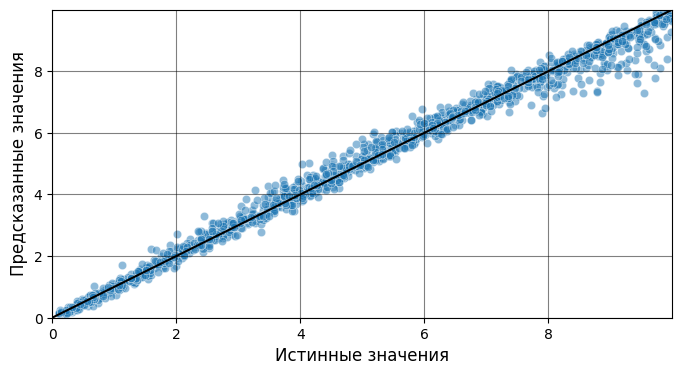

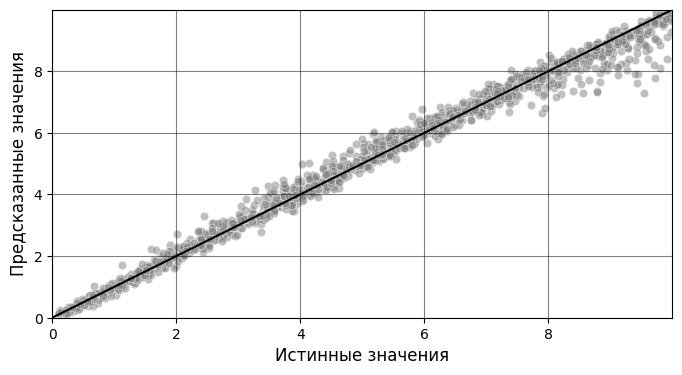

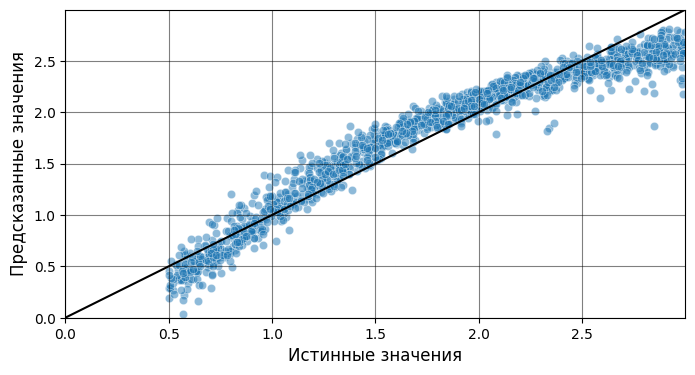

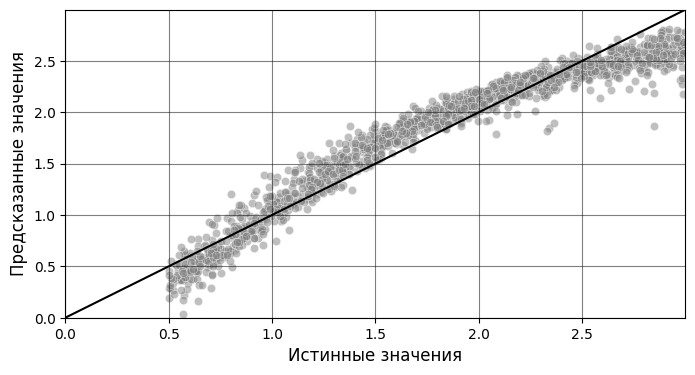

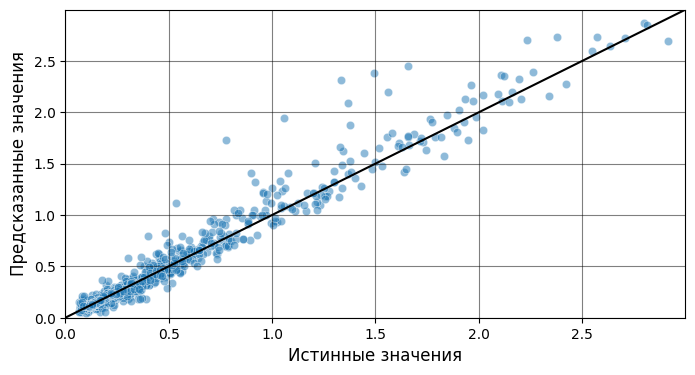

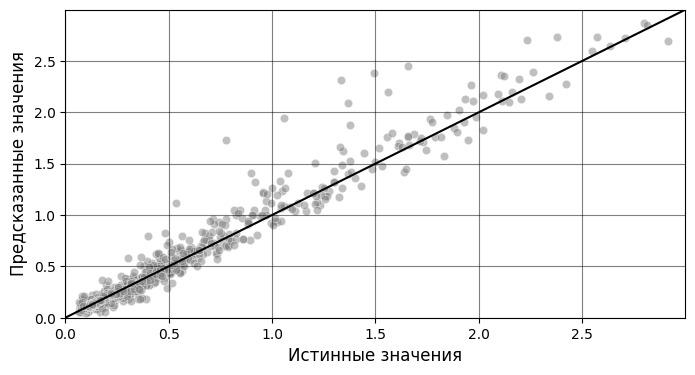

In [27]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/weibull/Untitled Folder/val1")

scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/weibull/Untitled Folder/val2")

scatter_plot(test_intervals_Y[:,2], pred[:,2], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/weibull/Untitled Folder/val3")

In [44]:
test_intervals_Y

array([[1.42227613, 2.88803216, 0.78863502],
       [4.90383621, 2.19365678, 0.23025966],
       [0.66810421, 2.52018938, 1.68661246],
       ...,
       [6.47020775, 2.02387509, 0.17443082],
       [6.65168586, 1.50045067, 0.16654011],
       [2.67764816, 0.91170681, 0.35741853]])

In [51]:
def line_plot(y_test, y_pred, plot_value, value, plot_name=None):

    plot_data = [('white', 'red', '#4682B4', ''), ('white', 'black', 'gray', '_colored')]
    for color, marker_color, line_color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create separate figures
        sns.lineplot(y_test, label='Истинное значение', color=color, marker='o', markersize=5, markerfacecolor=marker_color)
        sns.lineplot(y_pred, label='Оцененное значение', color=line_color)  # Simplified
        plt.xlim(0, plot_value)
        plt.ylim(0, round(max(test_intervals_Y[:plot_value, value])))
        plt.xlabel('Количество данных', fontsize=12)
        plt.ylabel('Значение данных', fontsize=12)
        plt.grid(alpha=0.5, color='black')
        plt.legend(loc=1) # Add a legend to distinguish lines

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")

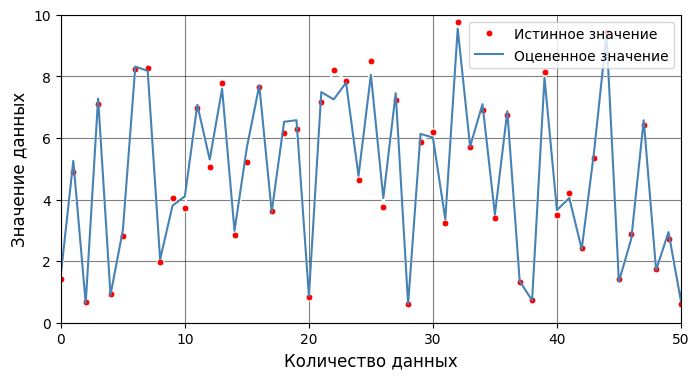

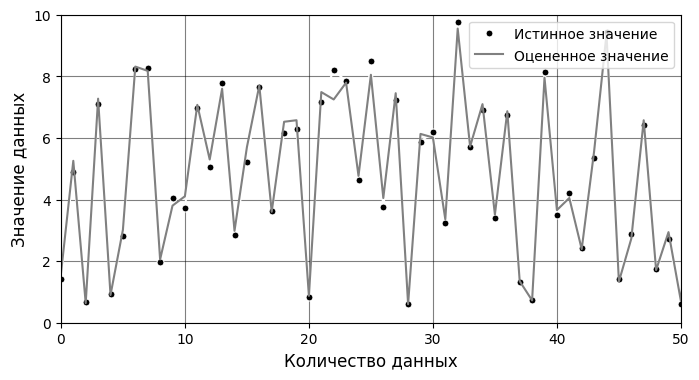

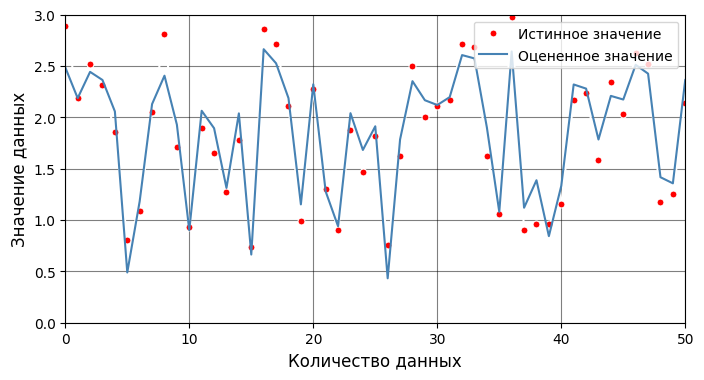

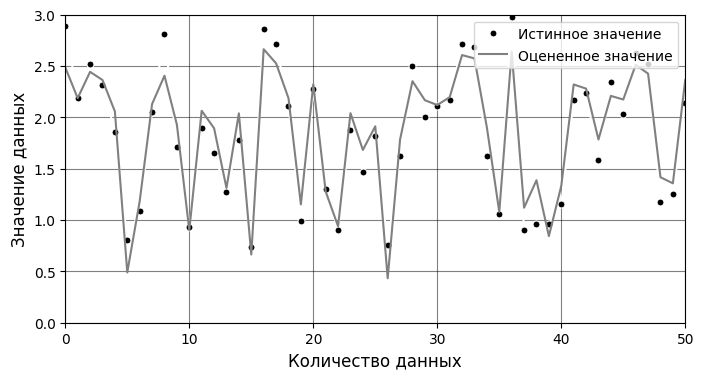

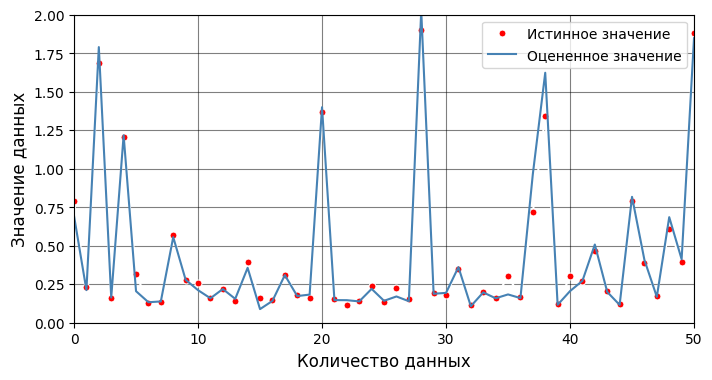

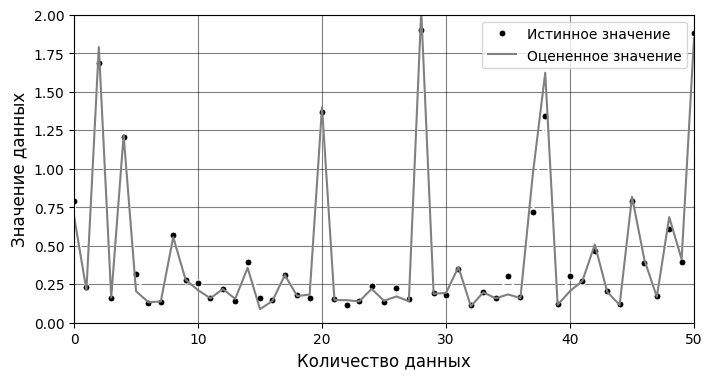

In [52]:
line_plot(test_intervals_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/weibull/Untitled Folder/val1")
line_plot(test_intervals_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/weibull/Untitled Folder/val2")
line_plot(test_intervals_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/weibull/Untitled Folder/val3")

In [54]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/weibull/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/weibull/catboost_info/test_error.tsv', sep='\t', index_col=0)

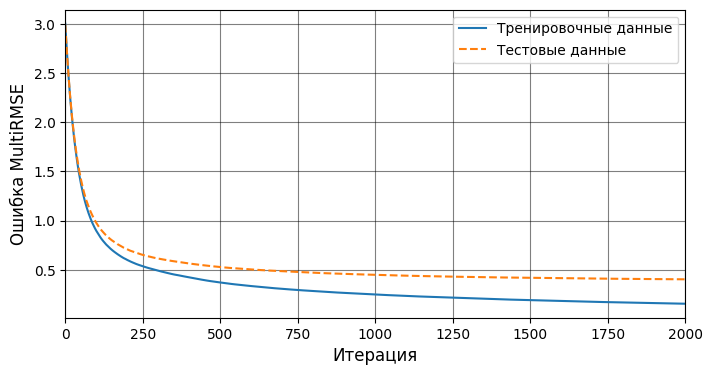

In [55]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, 2000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/weibull/catboost_train_colored_inter.pdf', bbox_inches="tight")

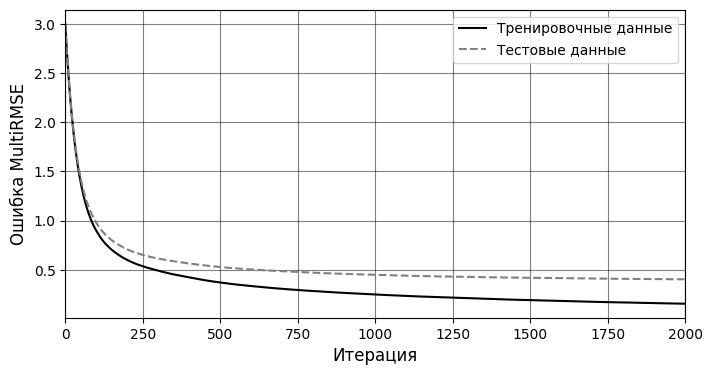

In [56]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, 2000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/catboost_train_inter.pdf', bbox_inches="tight")

## Catboost статистика

In [57]:
train_stat_M = calculate_statistics(train_intervals_X)
test_stat_M = calculate_statistics(test_intervals_X)
val_stat_M = calculate_statistics(val_intervals_X)

In [58]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 1000,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 1000,
    #"early_stopping_rounds": 1000,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.003
}

gamma_stat = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
gamma_stat.fit(train_stat_M, train_intervals_Y, eval_set=(val_stat_M, val_intervals_Y), use_best_model=True)

0:	learn: 2.9770755	test: 2.9665382	best: 2.9665382 (0)	total: 5.3ms	remaining: 5.3s
999:	learn: 0.0665875	test: 0.0741473	best: 0.0741473 (999)	total: 2.4s	remaining: 0us

bestTest = 0.07414730642
bestIteration = 999



In [59]:
pred = gamma_stat.predict(test_stat_M)

In [98]:
gamma_stat.save_model("weibull")

### Метрики

In [60]:
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "value1")
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_intervals_Y[:, 2], pred[:, 2], "value3")


value1
MAE: 0.045
MSE: 0.004
RMSE: 0.063
MAPE: 1.371%
R² Score: 1.000

value2
MAE: 0.019
MSE: 0.001
RMSE: 0.025
MAPE: 1.220%
R² Score: 0.999

value3
MAE: 0.013
MSE: 0.002
RMSE: 0.048
MAPE: 1.684%
R² Score: 0.998


In [61]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]
test_df_Y = np.array(test_df)[:, 10000:10002]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [62]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [63]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	4413.217
relative_error_mean_median:	222.177
relative_error_std_mean:	168034.579
relative_error_std_median:	1523.924
abs_mean:	9665.320
abs_median:	9941.000


### Рисунки

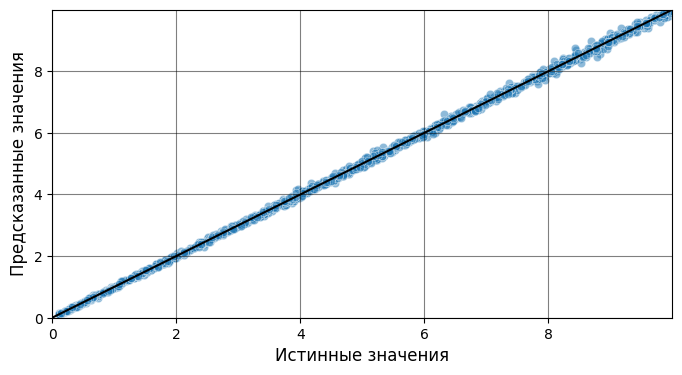

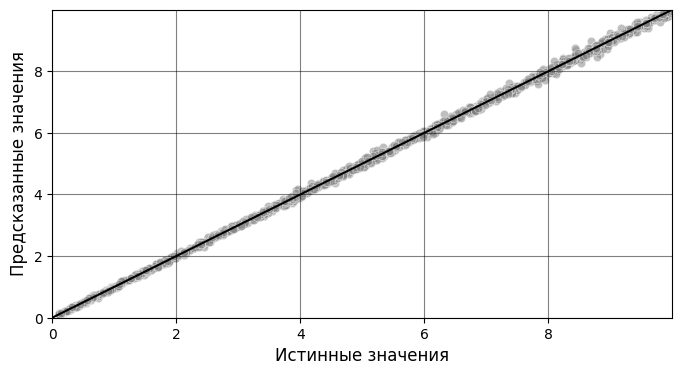

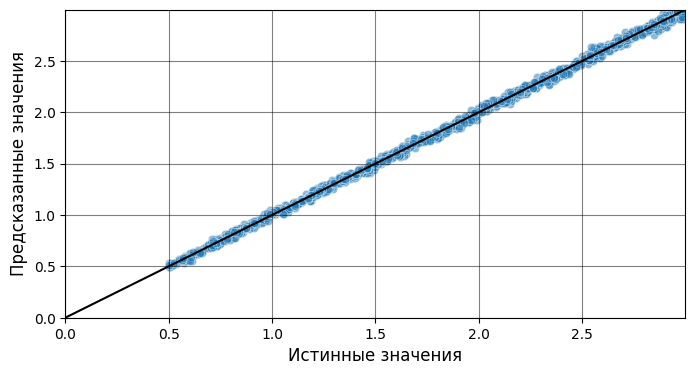

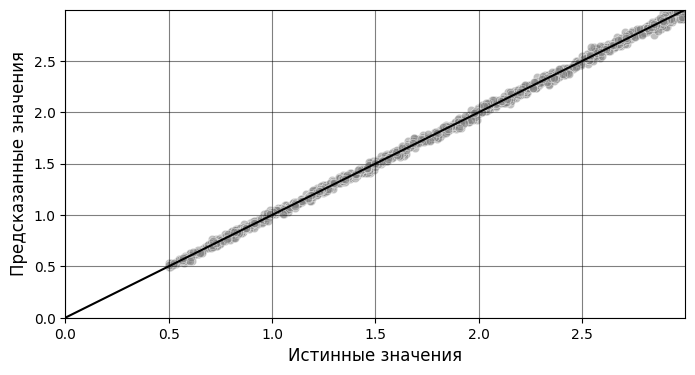

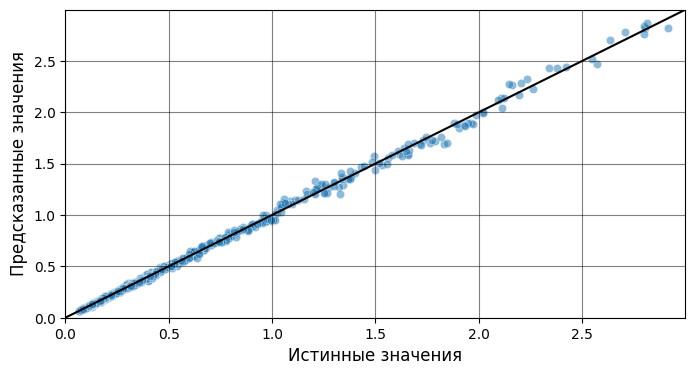

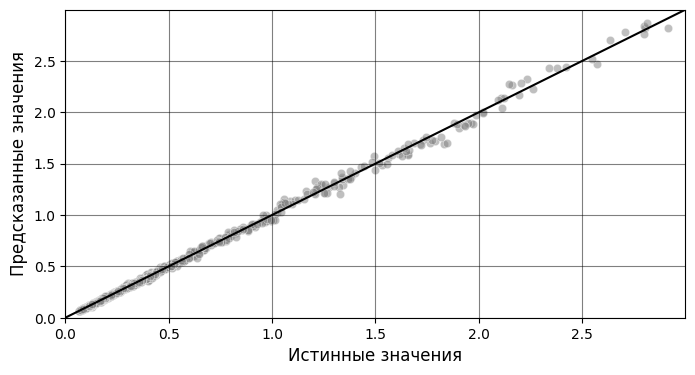

In [64]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/weibull/Untitled Folder/val1_stat")

scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/weibull/Untitled Folder/val2_stat")

scatter_plot(test_intervals_Y[:,2], pred[:,2], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/weibull/Untitled Folder/val3_stat")

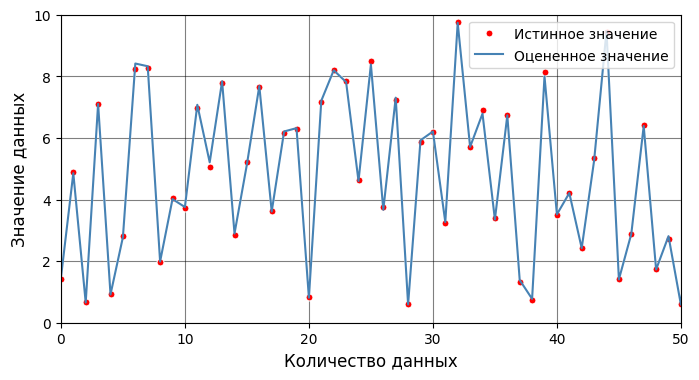

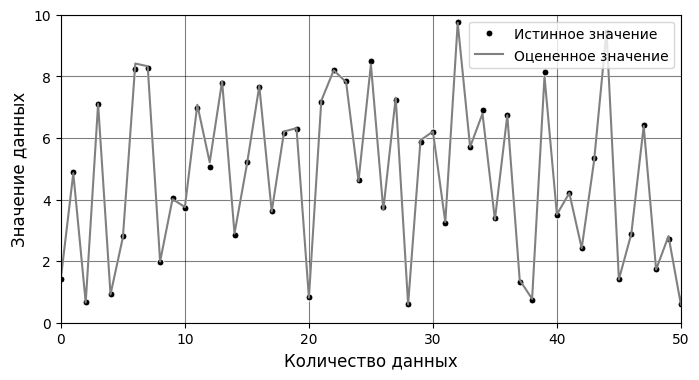

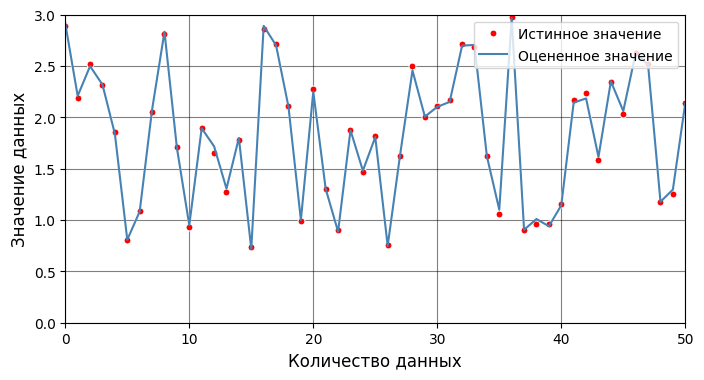

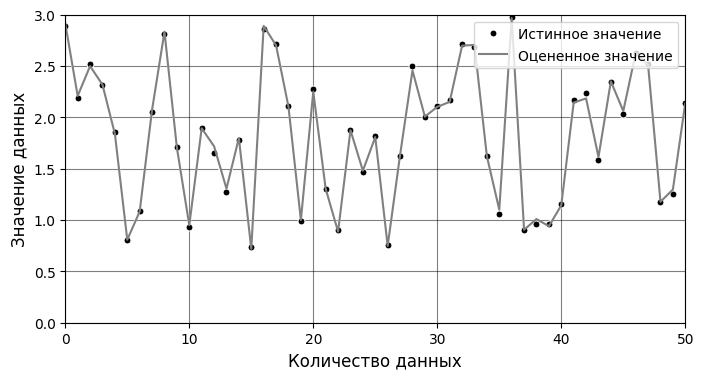

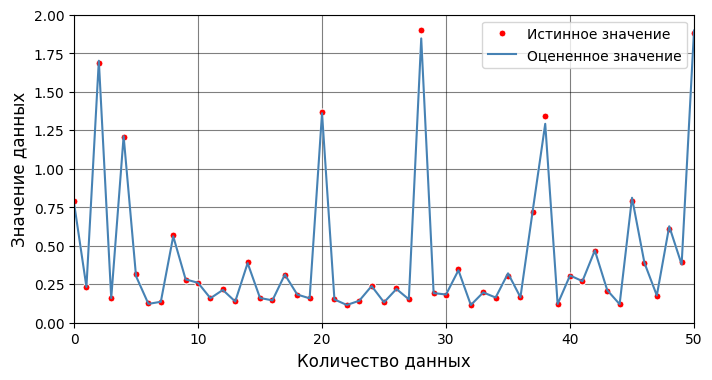

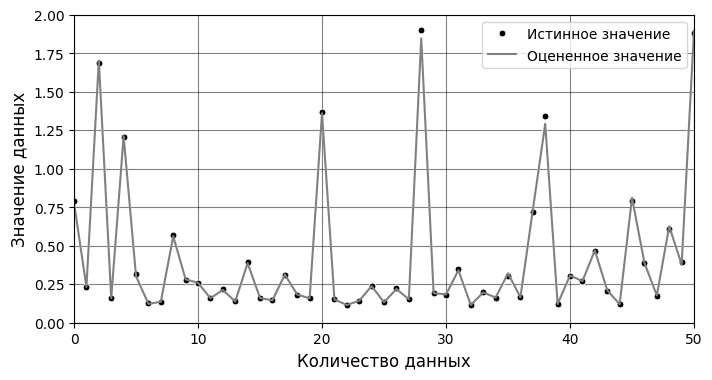

In [65]:
line_plot(test_intervals_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/weibull/Untitled Folder/val1_stat")
line_plot(test_intervals_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/weibull/Untitled Folder/val2_stat")
line_plot(test_intervals_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/weibull/Untitled Folder/val3_stat")

In [66]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/weibull/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/weibull/catboost_info/test_error.tsv', sep='\t', index_col=0)

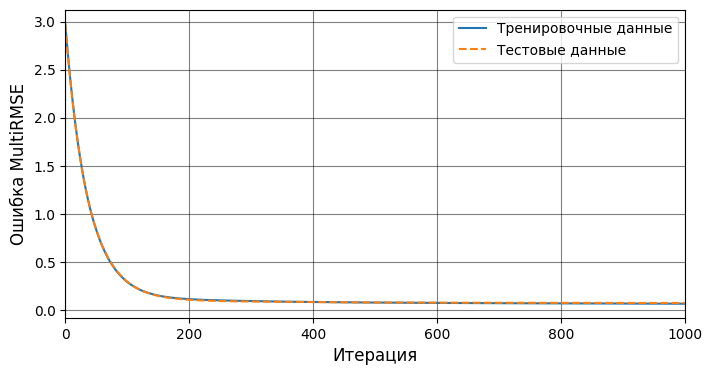

In [68]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, 1000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/weibull/catboost_train_colored__stat.pdf', bbox_inches="tight")

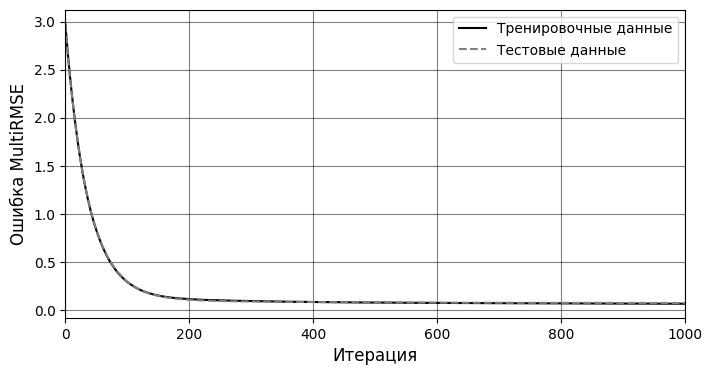

In [69]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, 1000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/catboost_train_stat.pdf', bbox_inches="tight")

## Catboost моменты

In [70]:
train_X = np.array(train_df)[:, :10000]
train_Y = np.array(train_df)[:, 10000:]
test_X = np.array(test_df)[:, :10000]
test_Y = np.array(test_df)[:, 10000:]
val_X = np.array(val_df)[:, :10000]
val_Y = np.array(val_df)[:, 10000:]

In [84]:
train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,alpha,beta,lmbd
9254,13.163479,17.118784,20.128420,24.941350,26.406315,26.521530,33.421142,35.209596,46.978423,55.818044,58.255001,60.647579,60.846004,64.193547,72.807501,78.259356,93.213088,110.914558,111.413315,115.989024,126.381549,133.338267,137.501961,141.361258,146.845347,151.104038,151.733173,157.717482,173.686235,177.382742,177.849383,189.249753,198.021139,199.170728,204.416547,207.885022,213.339809,224.720222,228.280625,234.986881,...,79812.660421,79823.401790,79835.751117,79850.016543,79851.170941,79854.884436,79864.669848,79867.010713,79870.477722,79872.269120,79875.588480,79878.328437,79882.718923,79885.195186,79902.161282,79903.309505,79915.648333,79931.606040,79944.039705,79953.491002,79958.167298,79991.292407,79995.108556,79995.475038,79995.729129,79996.680237,79997.581729,80003.322953,80012.604872,80019.994697,80023.727871,80034.012943,80035.390603,80041.896510,80054.850150,80065.447382,80070.930024,8.310566,1.098079,0.124632
1561,5.487919,16.027151,19.506784,29.465801,30.434216,30.734151,40.543840,50.377134,56.663165,57.210991,63.999335,66.153362,78.264744,89.764803,91.808079,95.704587,100.889292,102.048235,111.470244,125.447230,126.083960,132.440051,136.941480,138.177137,147.484599,155.845304,159.769541,165.152341,171.664193,174.251476,175.417177,176.958967,178.662883,182.527913,185.689381,188.052940,192.193875,197.827730,200.254877,211.045128,...,61238.575079,61245.095471,61248.166512,61252.068303,61258.682631,61265.719563,61268.522432,61273.261647,61285.507612,61286.195213,61299.582278,61311.989588,61318.348711,61321.011961,61324.566095,61335.304447,61337.040361,61344.114047,61349.559135,61355.190851,61357.951995,61358.039639,61369.511405,61372.726746,61374.194103,61385.517341,61393.916868,61410.864394,61423.281864,61426.628800,61434.730965,61442.081843,61442.945184,61454.722139,61461.896696,61462.910460,61464.432363,6.807429,1.447787,0.161977
1670,11.316340,12.775346,26.895438,38.165021,44.177729,48.950461,59.227534,80.930464,81.440400,95.416789,96.707611,110.976629,122.365579,124.504113,130.301036,139.697323,143.885299,148.714974,157.756401,159.825467,162.622062,167.315614,167.358284,177.888136,195.527748,202.045956,220.080556,233.299966,250.853195,259.771424,265.696344,285.281172,301.005001,306.031652,322.151872,350.629203,353.355331,356.086186,357.456709,359.098577,...,86859.577881,86884.374745,86898.920405,86899.764244,86906.942938,86928.719114,86933.828830,86942.236089,86946.347946,86961.181115,86976.109368,86993.313608,87003.866320,87017.967348,87023.463602,87024.000920,87028.422563,87038.089014,87052.178441,87059.339304,87094.296117,87099.755935,87106.229123,87111.381142,87114.424660,87124.522208,87138.582820,87146.787981,87156.424361,87161.244912,87170.252339,87192.825234,87216.498639,87222.846818,87227.225718,87236.266060,87236.846635,9.461258,1.273467,0.113949
6087,13.056104,23.578126,29.427211,34.128247,35.953934,41.547364,43.214641,45.519587,52.543298,56.512371,57.677537,62.122307,67.590017,72.176254,75.974863,84.383468,85.883024,96.193018,97.729994,108.667037,116.249424,124.444164,129.202881,132.291961,140.190785,147.022741,154.048440,156.057812,163.250909,166.408946,176.460238,180.186440,185.276974,196.021008,205.090037,210.942875,216.991775,218.882591,227.107426,234.249507,...,61278.091411,61286.309301,61293.569853,61299.823834,61304.779086,61309.057837,61317.092565,61325.711600,61329.538782,61334.551174,61342.691499,61343.490182,61345.909744,61353.510331,61354.720138,61360.038588,61370.021841,61379.798098,61383.934003,61392.469363,61396.243377,61407.987017,61410.933171,61411.059648,61414.051671,61422.104618,61423.296203,61427.499972,61434.979197,61438.612084,61440.319333,61447.045830,61456.773653

In [71]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 100,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 200,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.03
}

gamma_moments = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
gamma_moments.fit(train_X, train_Y, eval_set=(val_X, val_Y), use_best_model=True)

0:	learn: 2.9820809	test: 2.9718652	best: 2.9718652 (0)	total: 676ms	remaining: 22m 30s
100:	learn: 0.8938409	test: 0.8857637	best: 0.8857637 (100)	total: 41.3s	remaining: 12m 57s
200:	learn: 0.7867243	test: 0.7947216	best: 0.7947216 (200)	total: 1m 20s	remaining: 12m 3s
300:	learn: 0.7365145	test: 0.7606686	best: 0.7606686 (300)	total: 1m 59s	remaining: 11m 16s
400:	learn: 0.6937507	test: 0.7339661	best: 0.7339661 (400)	total: 2m 38s	remaining: 10m 32s
500:	learn: 0.6607159	test: 0.7140364	best: 0.7140364 (500)	total: 3m 16s	remaining: 9m 48s
600:	learn: 0.6317476	test: 0.6972454	best: 0.6972454 (600)	total: 3m 55s	remaining: 9m 7s
700:	learn: 0.6082877	test: 0.6835170	best: 0.6835170 (700)	total: 4m 35s	remaining: 8m 29s
800:	learn: 0.5895900	test: 0.6735786	best: 0.6735786 (800)	total: 5m 15s	remaining: 7m 51s
900:	learn: 0.5719728	test: 0.6656176	best: 0.6656084 (899)	total: 5m 55s	remaining: 7m 13s
1000:	learn: 0.5554085	test: 0.6565858	best: 0.6565858 (1000)	total: 6m 35s	remaini

In [72]:
pred = gamma_moments.predict(test_X)

### Метрики

In [74]:
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "value1")
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_intervals_Y[:, 2], pred[:, 2], "value3")


value1
MAE: 0.215
MSE: 0.175
RMSE: 0.418
MAPE: 5.162%
R² Score: 0.979

value2
MAE: 0.386
MSE: 0.222
RMSE: 0.471
MAPE: 26.153%
R² Score: 0.570

value3
MAE: 0.016
MSE: 0.007
RMSE: 0.083
MAPE: 1.546%
R² Score: 0.994


In [75]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]
test_df_Y = np.array(test_df)[:, 10000:10002]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [76]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [77]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	2054.921
relative_error_mean_median:	182.132
relative_error_std_mean:	39201.278
relative_error_std_median:	1106.172
abs_mean:	9772.358
abs_median:	9936.000


### Рисунки

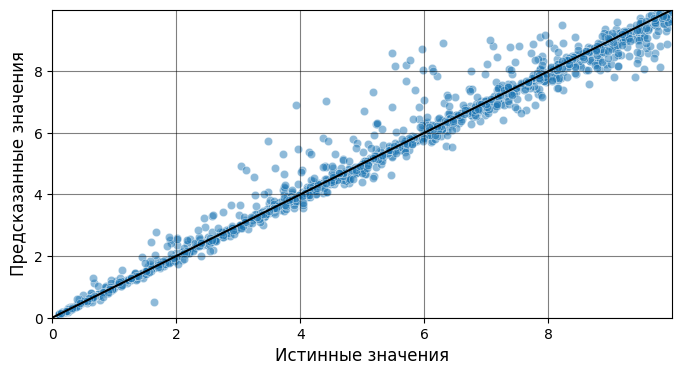

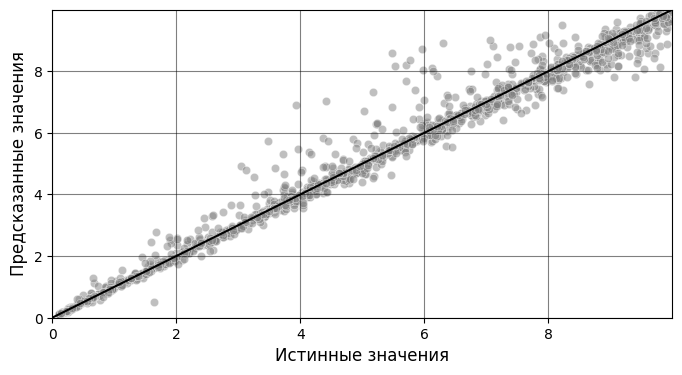

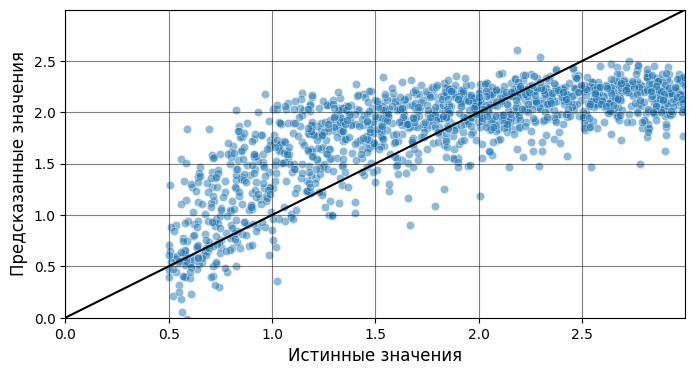

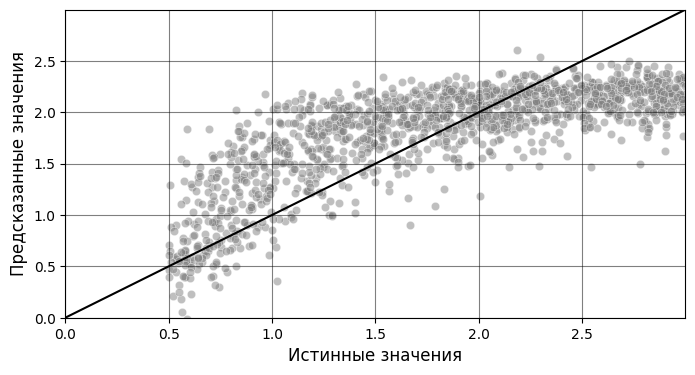

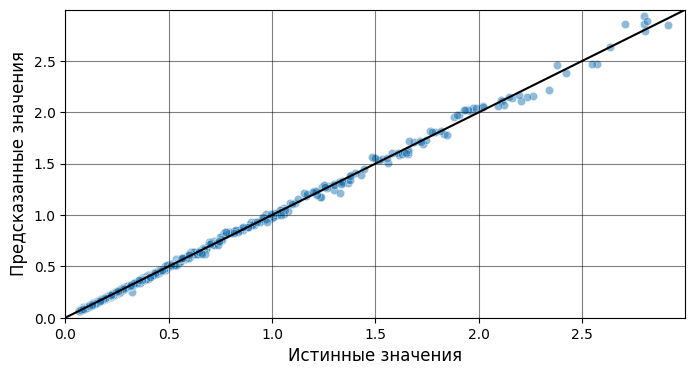

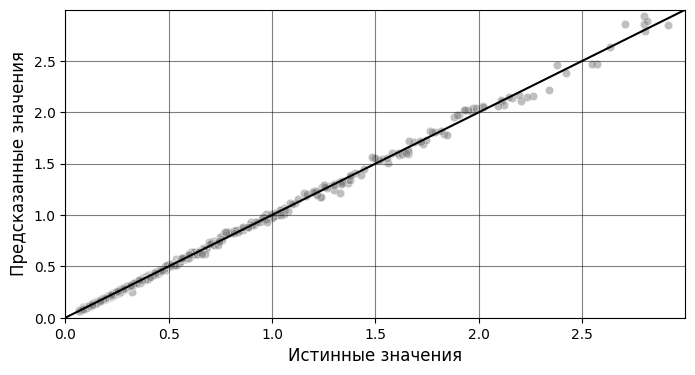

In [78]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/weibull/Untitled Folder/val1_moment")

scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/weibull/Untitled Folder/val2_moment")

scatter_plot(test_intervals_Y[:,2], pred[:,2], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/weibull/Untitled Folder/val3_moment")

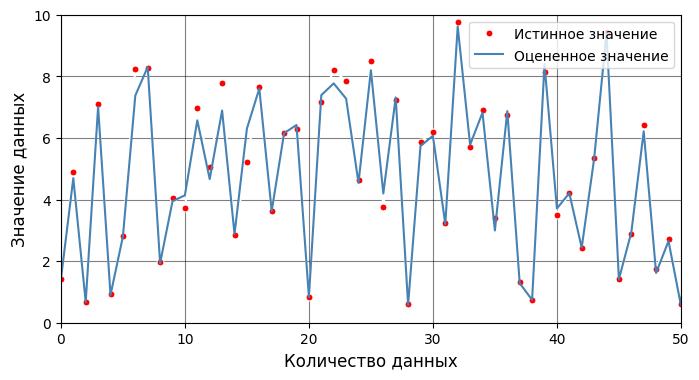

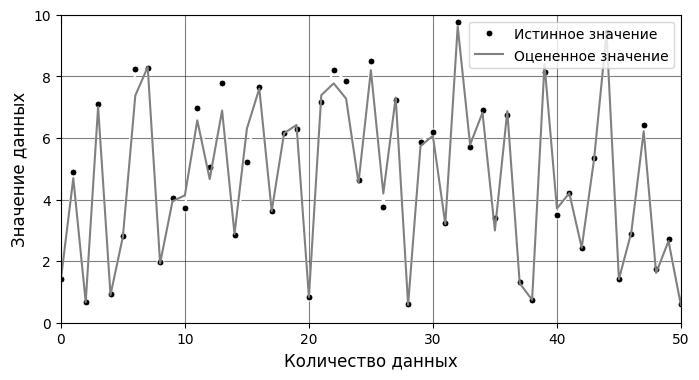

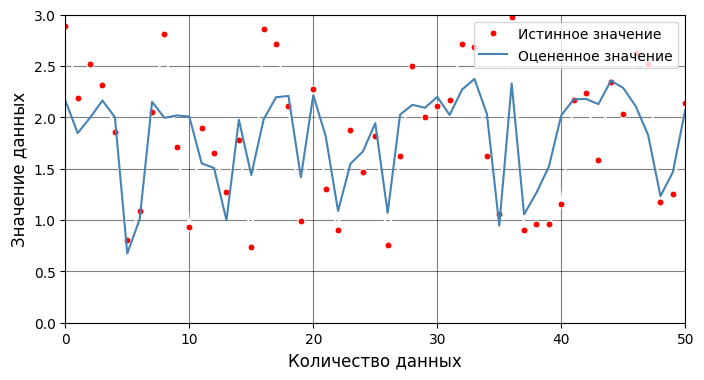

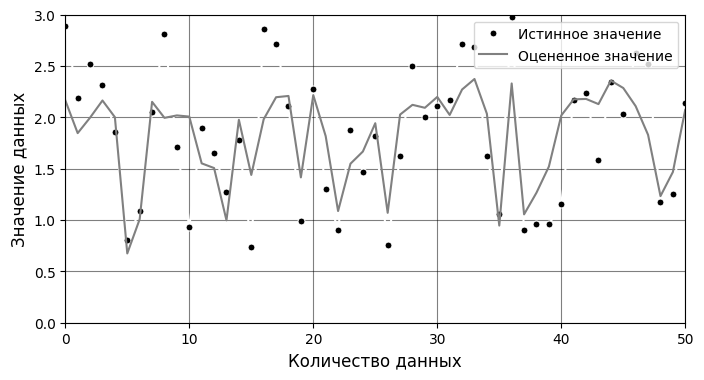

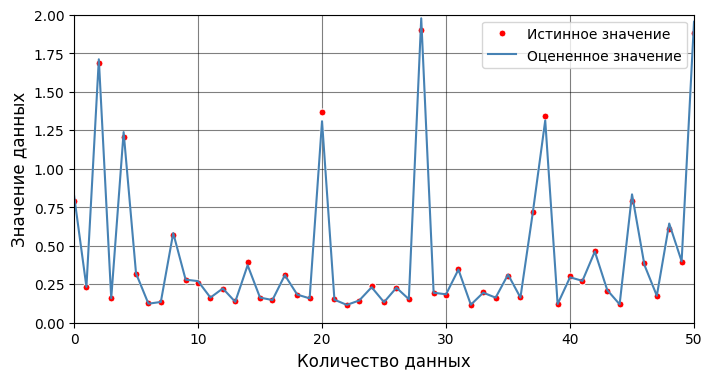

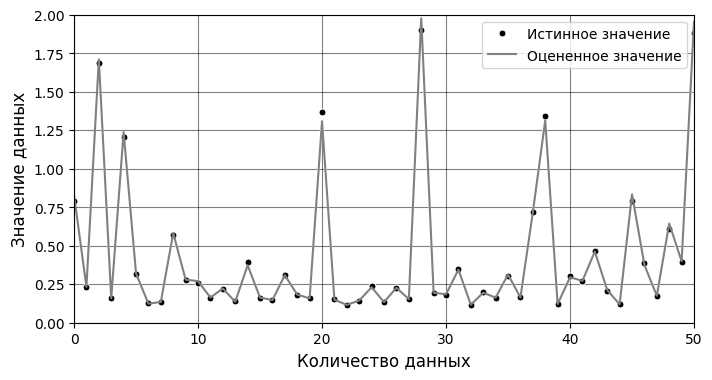

In [79]:
line_plot(test_intervals_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/weibull/Untitled Folder/val1_moment")
line_plot(test_intervals_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/weibull/Untitled Folder/val2_moment")
line_plot(test_intervals_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/weibull/Untitled Folder/val3_moment")

In [80]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/weibull/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/weibull/catboost_info/test_error.tsv', sep='\t', index_col=0)

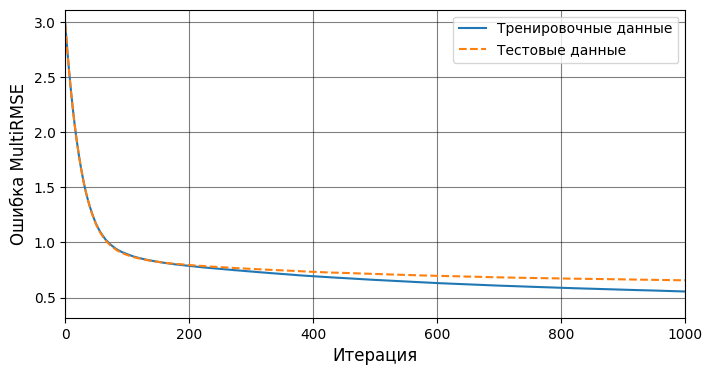

In [81]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, 1000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/weibull/catboost_train_colored_moment.pdf', bbox_inches="tight")

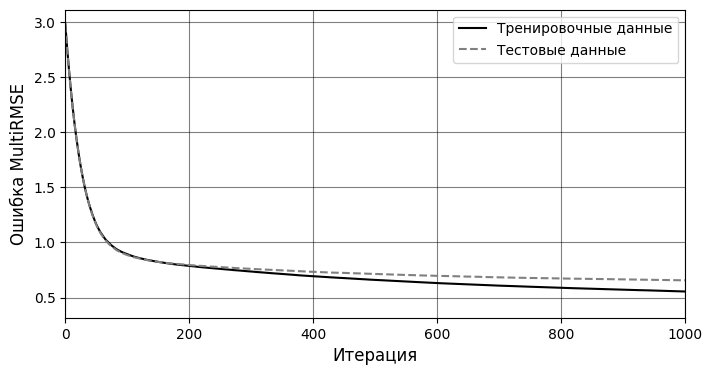

In [82]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, 1000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/catboost_train_moment.pdf', bbox_inches="tight")